In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 
import numpy as np
import os, shutil
import pandas, csv, json
import random
from datetime import datetime
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style({u'font.sans-serif':['simhei']})
plt.rcParams[u'font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False
import pandas as pd
import scipy
import math
from scipy.stats import genextreme as gev, gumbel_r, norm, gompertz
from scipy.special import gamma, factorial

from constants import * 
from utils import *

In [2]:

args = ["--no=-1"]
# args = ["--no=-1", "--skip_site"]
opt = parse(args)
same_seeds(opt.seed)


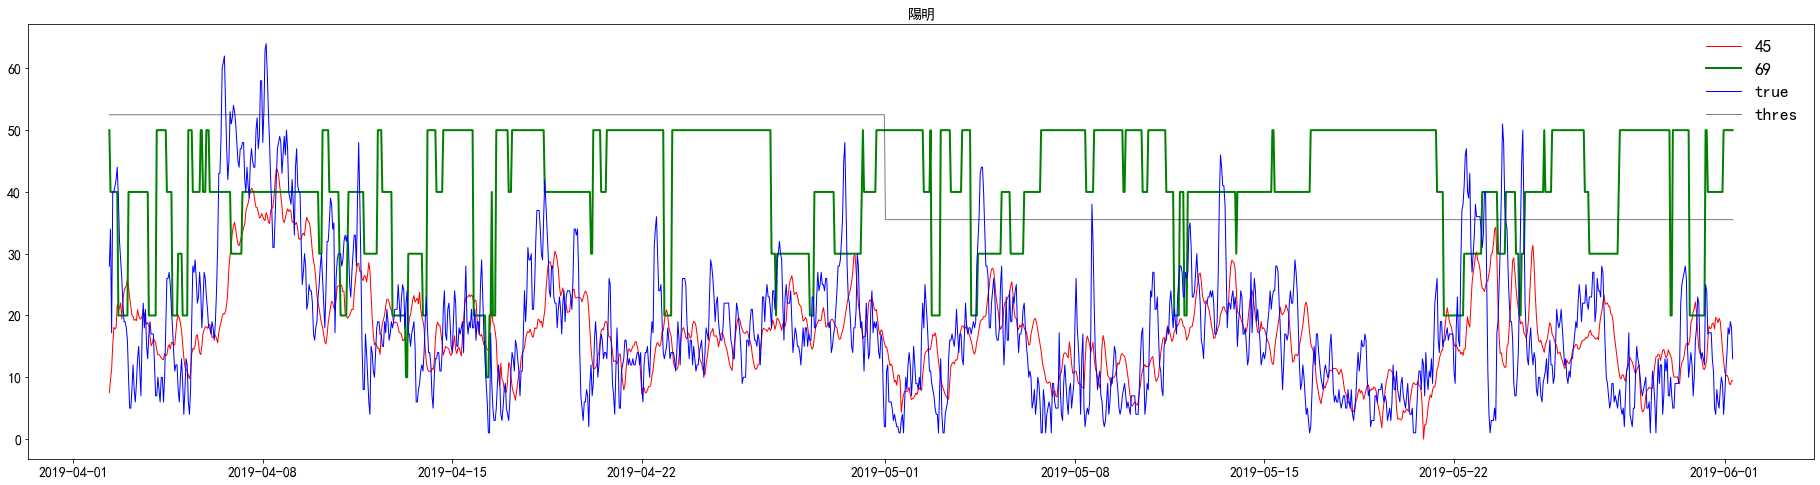

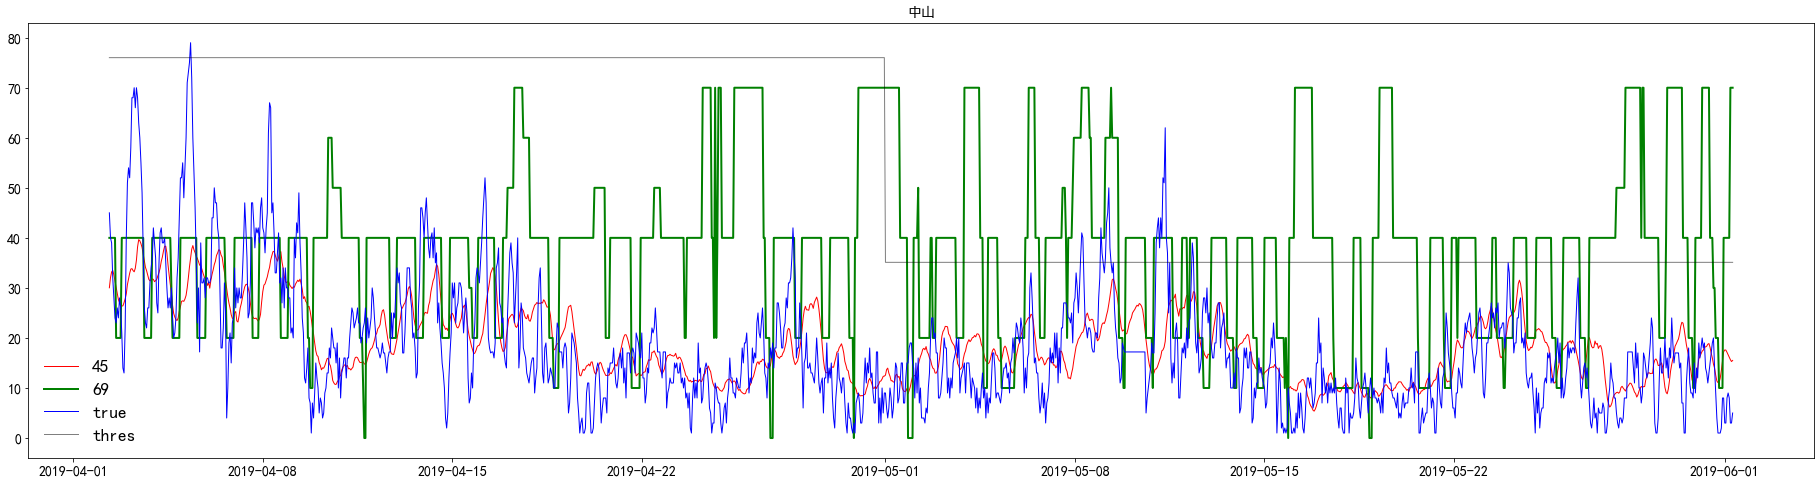

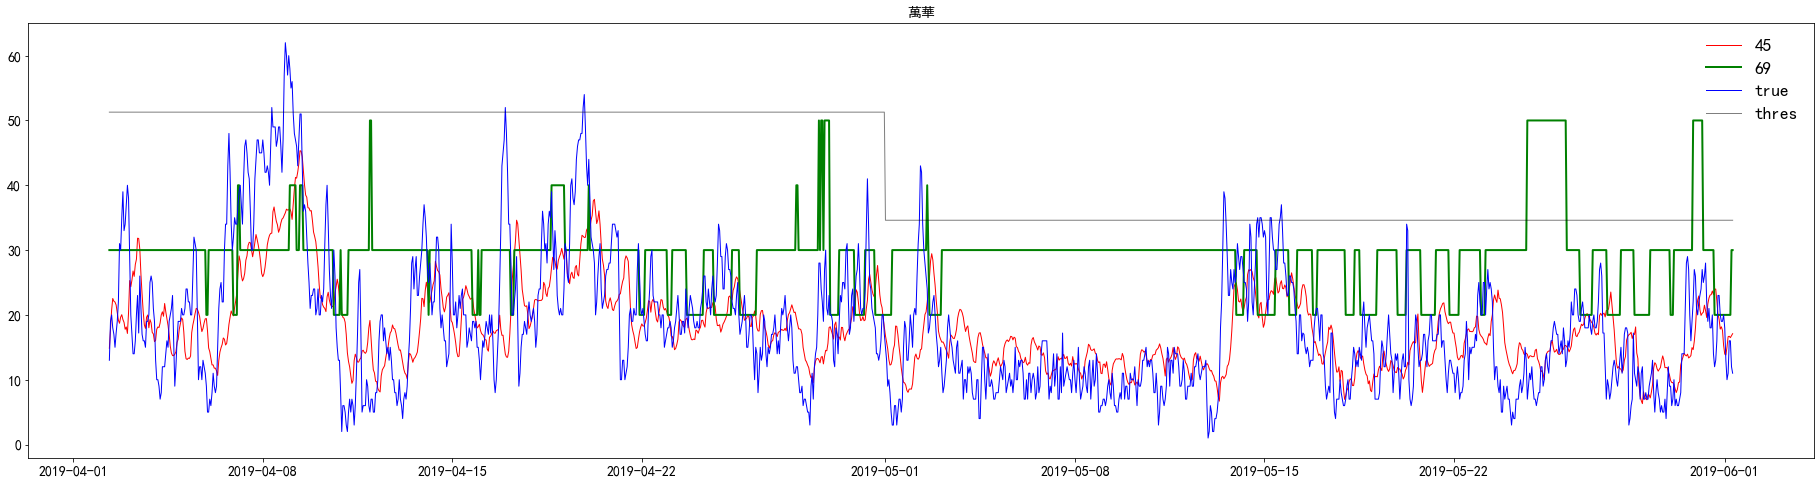

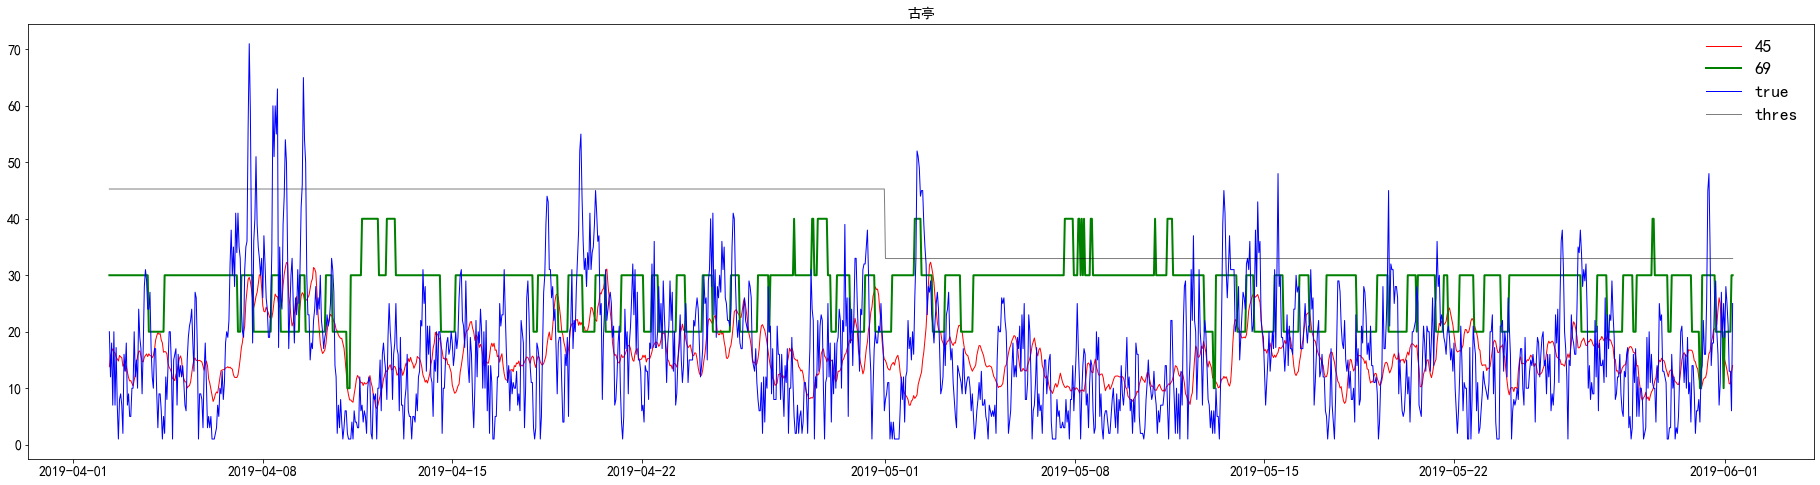

| site name |  rmse |
| - | - |
| 陽明 | 8.8630 |
| 中山 | 10.9409 |
| 萬華 | 8.1000 |
| 古亭 | 8.5299 |
| site name |  rmse |
| - | - |
| 陽明 | 32.3337 |
| 中山 | 28.4155 |
| 萬華 | 22.2577 |
| 古亭 | 19.9664 |


In [49]:
no = 46
origin_path = "data/origin/valid"
all_path    = f"split_method/results/{no}_all"
mgd_path    = f"split_method/results/{no}_merged"
thres_path  = "data/thres/valid"
source_size = 24
target_size = 8
def plot(sitename, a_path, a_label, b_path=None, b_label=None):
    a_pred = np.load(f"{a_path}/{sitename}.npy")
    b_pred = np.load(f"{b_path}/{sitename}.npy")
    true     = np.load(f"{origin_path}/{sitename}.npy")
    thres = np.load(f"{thres_path}/{sitename}.npy")
    date = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    
    true  = true[source_size+target_size:, 7:8]
    thres = thres[source_size+target_size:, 7:8]
    date  = date[source_size+target_size:]
    
    # Calculate QA
    a_rmse = np.sqrt(np.mean((a_pred-true)*(a_pred-true)))
    b_rmse = np.sqrt(np.mean((b_pred-true)*(b_pred-true)))
#     print(f"rmse {a_label}: {a_rmse: .4f}")
#     print(f"rmse {b_label}: {b_rmse: .4f}")
    
    st = 24 * 30 * i
    ed = 24 * 30 * (i+2)
    a_pred   = a_pred[st:ed]
    b_pred   = b_pred[st:ed]
    true     = true[st:ed]
    thres    = thres[st:ed]
    x        = date[st:ed]
    
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.plot(x, a_pred,    color='red',   lw=1,  label=a_label)
    ax.plot(x, b_pred,    color='green', lw=2,  label=b_label)
    ax.plot(x, true,      color='blue',  lw=1,  label='true')
    ax.plot(x, thres,     color='black', lw=1,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    return a_rmse, b_rmse

# site_list = ['陽明','淡水','士林','中山','萬華','觀音','古亭','永和','板橋','土城','新店']
site_list = ['陽明','中山','萬華','古亭']
tables = {}
for sitename in site_list:
#     print(sitename)
    no_a = 45
    no_b = 69
    i=3
    a_rmse, b_rmse = plot(sitename, 
         f"split_method/results/{no_a}_all", f"{no_a}", 
         f"split_method/results/{no_b}_discrete", f"{no_b}")
    tables[sitename] = (a_rmse, b_rmse)
#     print("hist")
#     hist(sitename, f"split_method/results/{47}_all", "47", f"split_method/results/{48}_all", "48")
#     break
print(f"\
| site name |  rmse |\n\
| - | - |\n\
| 陽明 | {tables['陽明'][0]:.4f} |\n\
| 中山 | {tables['中山'][0]:.4f} |\n\
| 萬華 | {tables['萬華'][0]:.4f} |\n\
| 古亭 | {tables['古亭'][0]:.4f} |")
print(f"\
| site name |  rmse |\n\
| - | - |\n\
| 陽明 | {tables['陽明'][1]:.4f} |\n\
| 中山 | {tables['中山'][1]:.4f} |\n\
| 萬華 | {tables['萬華'][1]:.4f} |\n\
| 古亭 | {tables['古亭'][1]:.4f} |")

(8737, 1) (8760, 16)
rmse 74:  2.7878


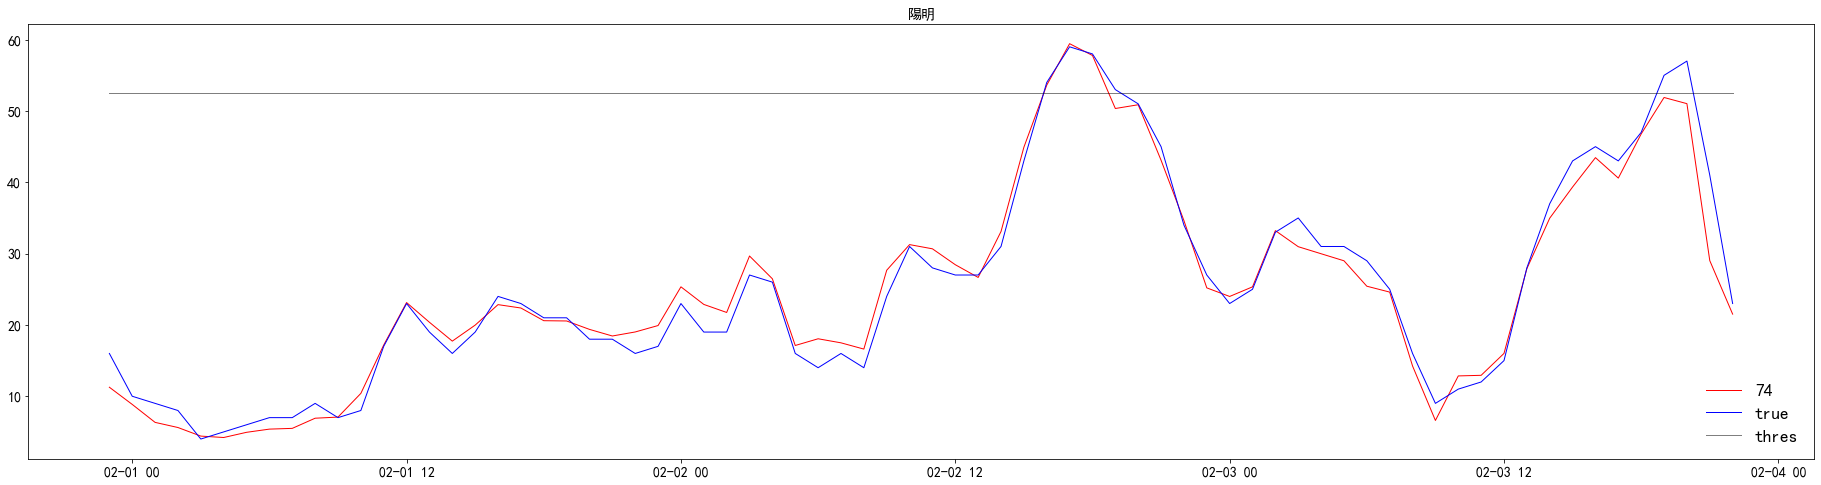

(8737, 1) (8760, 16)
rmse 74:  7.8371


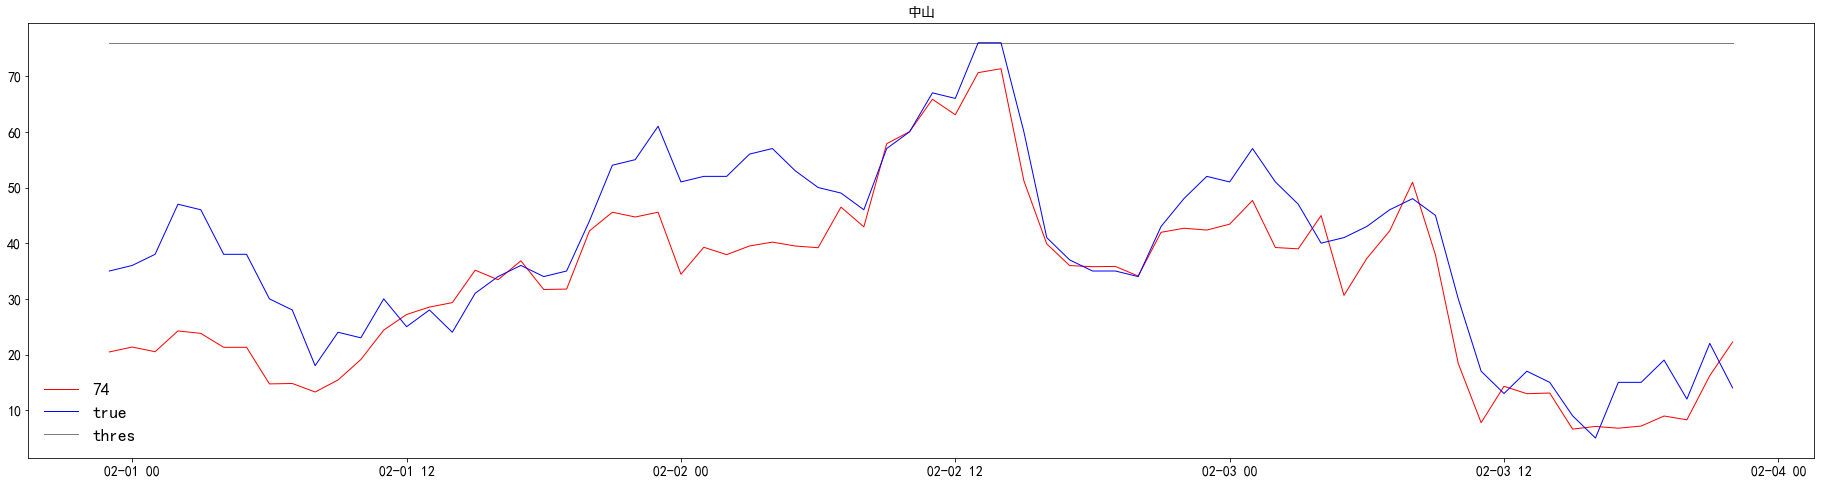

(8737, 1) (8760, 16)
rmse 74:  2.9157


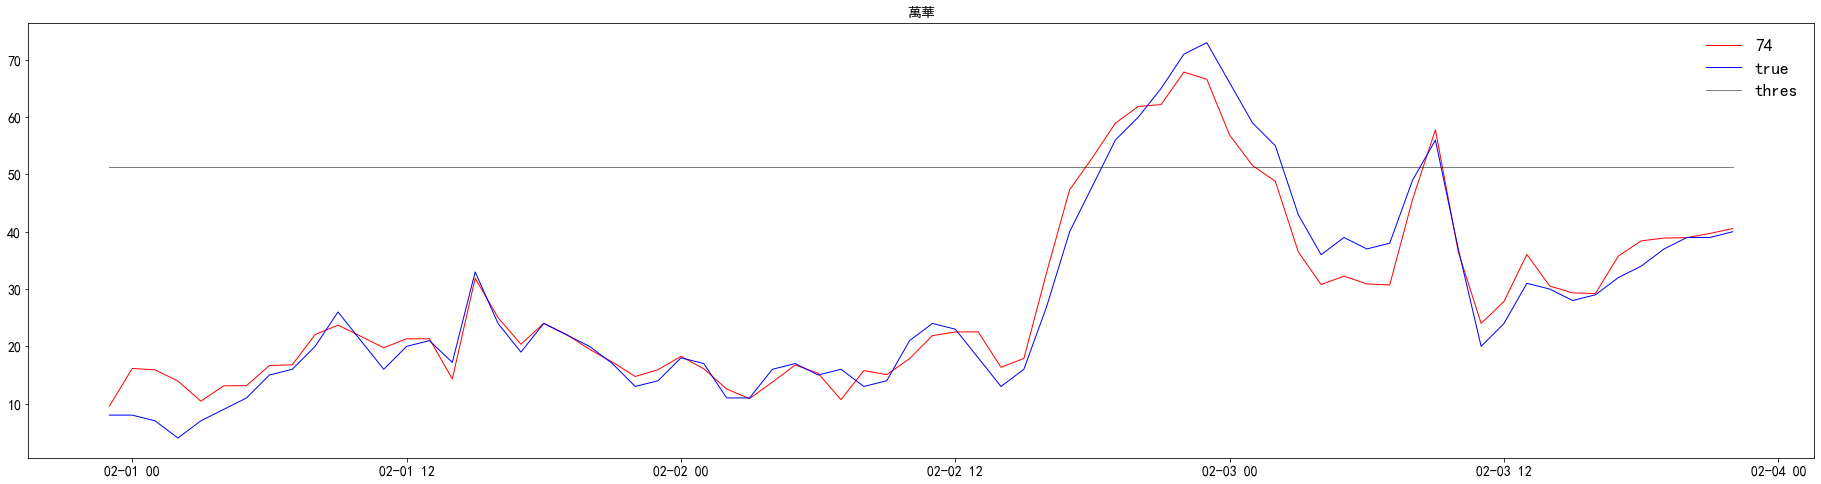

(8737, 1) (8760, 16)
rmse 74:  3.8435


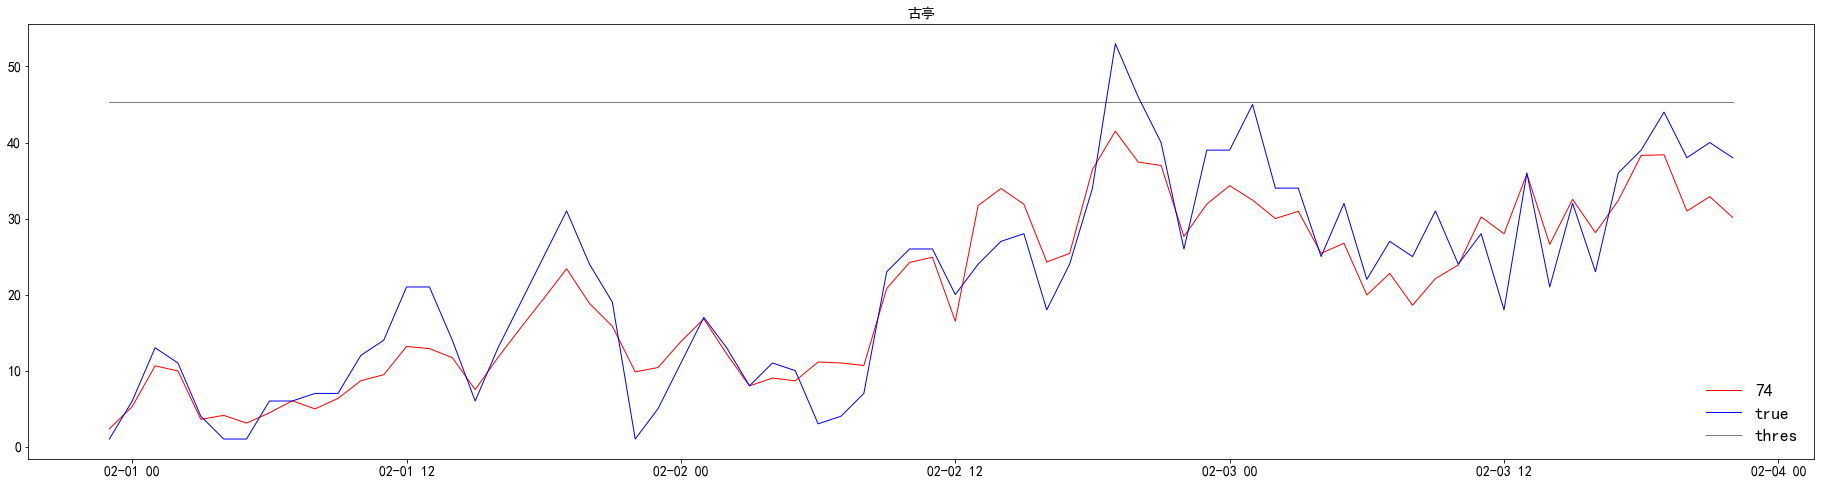

In [72]:
# For Unet
def plot(sitename, a_path, a_label):
    a_pred = np.load(f"{a_path}/{sitename}.npy")
    true     = np.load(f"{origin_path}/{sitename}.npy")
    thres = np.load(f"{thres_path}/{sitename}.npy")
    date = pd.date_range(start="2019-01-01 00:00",end="2019-12-31 23:00", freq='H')
    
    print(a_pred.shape, true.shape)
    true  = true [source_size-1:, 7:8]
    thres = thres[source_size-1:, 7:8]
    date  = date [source_size-1:]
    
    # Calculate QA
    a_rmse = np.sqrt(np.mean((a_pred-true)*(a_pred-true)))
    print(f"rmse {a_label}: {a_rmse: .4f}")
    
    st = 24 * 30 * i
    ed = 24 * 30 * i + 24*3
    a_pred   = a_pred[st:ed]
    true     = true  [st:ed]
    thres    = thres [st:ed]
    x        = date  [st:ed]
    
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    ax.plot(x, a_pred,    color='red',   lw=1,  label=a_label)
    ax.plot(x, true,      color='blue',  lw=1,  label='true')
    ax.plot(x, thres,     color='black', lw=1,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

site_list = ['陽明','中山','萬華','古亭']
method = ""
source_size = 24

for sitename in site_list:
#     print(sitename)
    no_a = 74
    i=1
    plot(sitename, 
         f"split_method/results/{no_a}_unet", f"{no_a}")
#     break

In [ ]:
def hist(sitename, a_path, a_label, b_path=None, b_label=None):
    
    def get_hist(data):
        x = np.arange(data.max())
        gev_fit = gev.fit(data)
        gev_hist = gev.pdf(x, gev_fit[0], gev_fit[1], gev_fit[2])
        norm_fit = norm.fit(data)
        norm_hist = norm.pdf(x, norm_fit[0], norm_fit[1])
        return x, gev_hist, norm_hist
        
    true   = np.load(f"{origin_path}/{sitename}.npy").astype(np.int)
    a_pred = np.load(f"{a_path}/{sitename}.npy").astype(np.int)
    
    true = true[source_size+target_size:, 7:8]
    a_pred[a_pred<0] = 0
    true[true<0] = 0
    
    true_x, true_gev, true_norm = get_hist(true)
    a_x, a_gev, a_norm = get_hist(a_pred) 
    if b_path:
        b_pred = np.load(f"{b_path}/{sitename}.npy").astype(np.int)
        b_pred[b_pred<0] = 0
        b_x, b_gev, b_norm = get_hist(b_pred)
        
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    
    ax.hist(true, 
        np.max(true),
        alpha=.4,
        label = 'true',
        color='blue',
        density=True,
        )
    ax.hist(a_pred, 
        np.max(a_pred),
        alpha=.4,
        label=a_label,
        color='red',
        density=True,
        )
    
#     ax.plot(a_x, a_gev,  color='red', lw=1, alpha=1,   linestyle='-.', label=f'{a_label}_gev')
#     ax.plot(a_x, a_norm, color='green', lw=1, alpha=1, linestyle='-.', label=f'{a_label}_norm')
    ax.plot(true_x, true_gev,  color='blue', lw=1, alpha=1,  label='true_gev')
    ax.plot(true_x, true_norm, color='dodgerblue', lw=1, alpha=1,  label='true_norm')
    if b_path:
        ax.plot(b_x, b_gev,  color='forestgreen', lw=3, alpha=1, linestyle=':', label=f'{b_label}_gev')
        ax.plot(b_x, b_norm, color='lime', lw=3, alpha=1, linestyle=':', label=f'{b_label}_norm')
        ax.hist(b_pred, 
            np.max(b_pred),
            alpha=.4,
            label=b_label,
            color='green',
            density=True,
        )

    
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [ ]:
all_path = "data/origin/all"
thres_path  = "data/thres/train"

site_list = ['陽明','淡水','士林','中山','萬華','觀音','古亭','永和','板橋','土城','新店']
# site_list = ['土城']
for sitename in site_list:
#     print(sitename)
    a_pred = np.load(f"{all_path}/{sitename}.npy")[:, 7]
    thres = np.load(f"{thres_path}/{sitename}.npy")[:, 7]
    fig, ax = plt.subplots(1, 1, figsize=(32,8))
    x = np.arange(a_pred.shape[0])
    ax.plot(x, a_pred,    color='blue', alpha=.5,  lw=1,  label='data')
    x = np.arange(thres.shape[0])
    ax.plot(x, thres,     color='black', lw=1,  alpha=.5, label='thres')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')

    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylim(top=150)
    plt.yticks(fontsize=14)
    plt.show()
#     break

In [ ]:
def gussion(x, position, width, height):
    return  height * math.sqrt(2*math.pi) * width * scipy.stats.norm.pdf(x, position, width)

def extreme(x, position, width, height, c=-0.1):
    return  height * math.sqrt(2*math.pi) * width * gev.pdf(x, c, position, width)

def kld(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

origin_all_path = opt.origin_all_dir

sitenames = ["陽明", "宜蘭"]
for idx, sitename in enumerate(sitenames):
    
    if opt.skip_site and sitename not in sample_sites:
        continue
    print(sitename)
    read_path = os.path.join(origin_all_path, f"{sitename}.npy")
    data = np.load(read_path)[:, 7].astype(np.int)

    data[data<0] = 0
    ratio = 1
    div = 8
    max_bin = np.max(data) // ratio + 1
    
    bins = [i * ratio for i in range(max_bin)]
    hist, _ = np.histogram(data, bins=bins, density=True)
#     try:
#         zero_list = np.where(hist==0)[0]
#         max_index = zero_list[0] if zero_list[0] != 0 else zero_list[1]
#         hist = hist[:max_index]
#     except:
#         pass
# #     print(hist)
#     try:
#         pos = np.argmax(hist) * ratio
#     except:
#         print(hist)
#     if pos == 0:
#         try:
#             pos = np.argmax(hist[1:]) * ratio
#         except:
#             print(pos, hist)
#     height = np.max(hist)
#     height = np.mean(hist[hist.argsort()[-3:][::-1]])
#     width = (len(hist)-pos)/ratio/div
#     print("loc:", pos, "scale:", width, "height:", height)
    
    # Limit boundary
#     data[data>(len(hist)*2)] = 0
    max_bin = np.max(data) // ratio + 1
    bins = [i * ratio for i in range(max_bin)]
    
    # Prepare distribution
    x = np.linspace(0, np.max(data), np.max(data))
    print(np.max(x))
    
    gev_fit = gev.fit(data)
    gev_dist = gev.pdf(x, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_kl = kld(hist, gev_dist)
    
    gumbel_r_fit = gumbel_r.fit(data)
    gumbel_r_dist = gumbel_r.pdf(x, gumbel_r_fit[0], gumbel_r_fit[1])
    gumbel_r_kl = kld(hist, gumbel_r_dist)
    
#     gompertz_fit = gompertz.fit(data)
#     gompertz_dist = gompertz.pdf(x, gompertz_fit[0], gompertz_fit[1], gompertz_fit[2])
#     gompertz_kl = kld(hist, gompertz_dist)
    
    norm_fit = norm.fit(data)
    norm_dist = norm.pdf(x, norm_fit[0], norm_fit[1])
    norm_kl = kld(hist, norm_dist)
    
    
    print(f'norm kl={norm_kl:.3e}'                                         ,'loc=',round(norm_fit[0],2), 'scale=',round(norm_fit[1],2))
    print(f'gumbel_r kl={gumbel_r_kl:.3e}',                                    'loc=',round(gumbel_r_fit[0],2), 'scale=',round(gumbel_r_fit[1],2))
#     print(f'gompertz kl={gompertz_kl:.3e}', 'shape=',round(gompertz_fit[0],2), 'loc=',round(gompertz_fit[1],2), 'scale=',round(gompertz_fit[2],2))
    print(f'gev kl={gev_kl:.3e}',      'shape=',round(gev_fit[0],2),      'loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2))
    
    
    # Plot 
    fig, ax = plt.subplots(1, 1, figsize=(16,8))
    ax.plot(x, norm_dist,    color='red', lw=1, alpha=1, label='norm')
    ax.plot(x, gumbel_r_dist,    color='blue', lw=1, alpha=1, label='gumbel_r')
#     ax.plot(x, gompertz_dist,    color='purple', lw=1, alpha=1, label='gompertz')
    ax.plot(x, gev_dist,     color='green', lw=1, alpha=1, label='genextreme')
    ax.legend(loc='best', frameon=False, fontsize='xx-large')
    
    ax.hist(data, 
            np.max(data),
#             bins=bins,
            alpha=0.6,
            density=True
            )
    plt.title(f"{sitename}", fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
#     break
    

In [ ]:
# 國維的 code 

def GEV(x,u,sigma,k):
    z = ((x-u)/sigma)
    distribution = (1/sigma)*(np.exp(-(1+k*z)**(-1/k)))*((1+k*z)**(-1-1/k))
    return(distribution)
def plot(x,u,sigma,k):
    xx = np.arange(np.max(x))
    gev_fit = gev.fit(x)
    gev_pdf = gev.pdf(xx, gev_fit[0], gev_fit[1], gev_fit[2])
    gev_estimator = GEV(xx,u=u,sigma=sigma,k=k)
#     gev_estimator = GEV(xx,u=gev_fit[1],sigma=gev_fit[2],k=gev_fit[0])
    print('loc=',round(gev_fit[1],2), 'scale=',round(gev_fit[2],2), 'shape=',round(gev_fit[0],2))
    plt.figure(figsize=(16,8))
    plt.hist(x, np.max(x), density=True, alpha=0.6, label='Data')
    plt.plot(xx, gev_pdf, 'r--', label='Scipy Auto Fit')
    plt.plot(xx, gev_estimator, 'b--', label='L-moments estimator')
    plt.legend()
    plt.show()

float_point = 4

sitename = "陽明"
read_path = os.path.join(origin_all_path, f"{sitename}.npy")
x = np.load(read_path)[:, 7].astype(np.int)
x[x<0] = 0

n = x.shape[0]
r = [0,1,2]
b_0=0;b_1=0;b_2=0
for i in range(n):
    b_0 = b_0+(   x[i] * ((i-r[0])/(n*(n-r[0])))   )
    b_1 = b_1+(   x[i] * ((i-r[0])*(i-r[1]))/(n*(n-r[0])*(n-r[1]))   )
    b_2 = b_2+(   x[i] * ((i-r[0])*(i-r[1])*(i-r[2]))/(n*(n-r[0])*(n-r[1])*(n-r[2]))   )
print(b_0,b_1,b_2)
lambda_1 = round(  b_0  ,float_point)
lambda_2 = round(  ((2*b_1) - b_0)  ,float_point)
lambda_3 = round(  ((6*b_2)-(6*b_1)+b_0)  ,float_point)
print('lambda_1=',lambda_1,'lambda_2=',lambda_2,'lambda_3=',lambda_3)
tau_3 = round(  lambda_3/lambda_2  ,float_point)
print('tau_3=',tau_3)
c = round(  (2/(3+tau_3)) - (np.log(2)/np.log(3))  ,float_point)
print('c=',c)
k = round(  (7.8590*c)+(2.9554* (c**2))  ,float_point)    #(7.8590*c)+(2.9554* (c**2))
print('k=',k)
a = round(    ((lambda_2*k) / ((1-(2**-k)) * float(gamma(1+k))))   ,float_point)
print('scale=',a)
xi = round(    lambda_1 - ((a/k)*(float(gamma(1+k)-1)))   ,float_point)
print('loc=',xi)
plot(x,u=xi,sigma=a*2,k=k)
#Gumbel's type I (k=0), Frechet's type II (k<0), Weibull or type III (k>0)
#x = np.arange(35)
#for k not equal 0 , x < xi + (a/k)
#gev_cdf = np.exp(-((1-(k*((x-xi)/a)))**(1/k)))